In [28]:
! pip install verde harmonica pandas matplotlib

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import harmonica as hm
import verde as vd
import pandas as pd
import warnings

In [30]:
warnings.filterwarnings('ignore')

In [ ]:
# Pra um determinado tamanho de bloco, calcular quantos blocos tem na area
# A partir disso definir o n_splits

# Levantamento aleatório

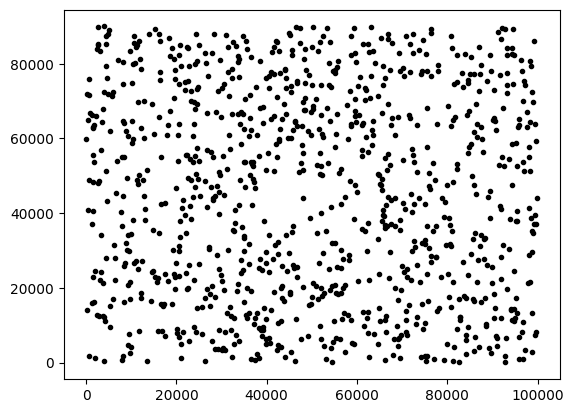

In [31]:
# Gerando a malha do levantamento com pontos aleatórios

region = [0, 100e3, 0, 90e3]
coordinates = vd.scatter_points(region, size=1000, extra_coords=1000, random_state=123)

plt.plot(coordinates[0], coordinates[1], ".k")

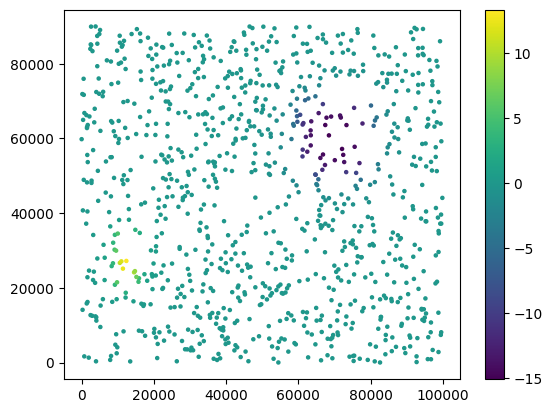

In [32]:
# Gerando os prismas, com suas densidades, e calculando o efeito gravitacional deles

prismas = [
    [10e3, 15e3, 20e3, 35e3, -1e3,  0],
    [60e3, 80e3, 50e3, 70e3, -2e3,  -0.5e3],
]
densidades = [500, -300]
gz = hm.prism_gravity(coordinates, prismas, densidades, field="g_z")

plt.scatter(coordinates[0], coordinates[1], s=5, c=gz)
plt.colorbar()

In [33]:
# Ajustando um modelo de fontes de equivalentes com damping=1 a uma profundidade de 1000m

fontes = hm.EquivalentSourcesGB(damping=1,depth=1e3)
altura = np.zeros(1000)
fontes.fit([coordinates[0],coordinates[1],altura],data=gz) 

EquivalentSourcesGB(damping=1, depth=1000.0)

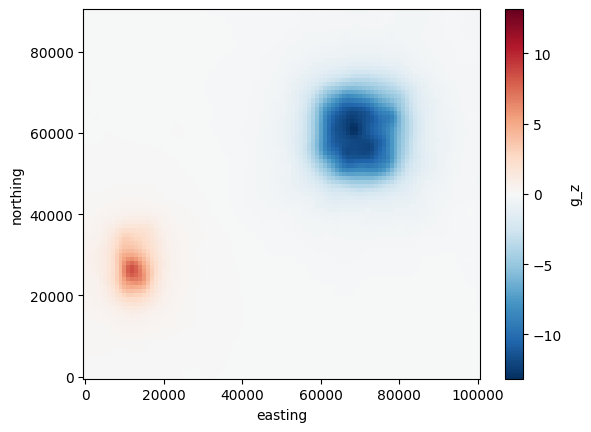

In [34]:
# Gerando a malha das fontes equivalentes

grid_coords_eq = vd.grid_coordinates(region,spacing=1e3,extra_coords=1000)
gz_grid_eq = fontes.grid(grid_coords_eq,data_names="g_z")
gz_grid_eq.g_z.plot()

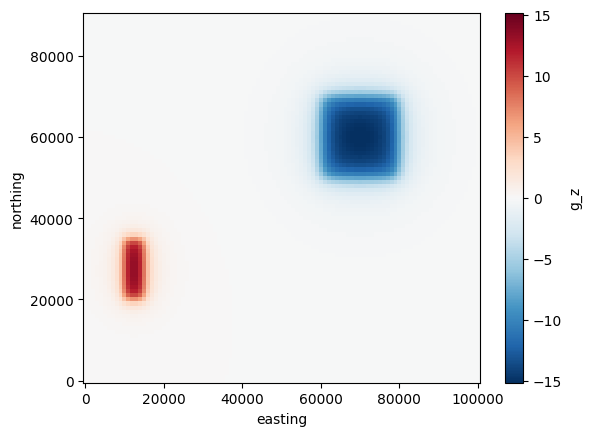

In [35]:
# Gerando uma malha regular equivalente ao levantamento aleatório. 
# Quero calcular a diferença entre o levantamento aleatório e a malha regular das fontes equivalentes. 
# Como a malha das fontes equivalentes é uma malha regular, preciso que a malha do levantamento também seja regular para que a conta seja feita.

grid_coords = vd.grid_coordinates(region, spacing=1e3, extra_coords=1000)
gz_grid = hm.prism_gravity(grid_coords, prismas, densidades, field="g_z")
grid_true = vd.make_xarray_grid(grid_coords, gz_grid, data_names="g_z", extra_coords_names="upward")
grid_true.g_z.plot()


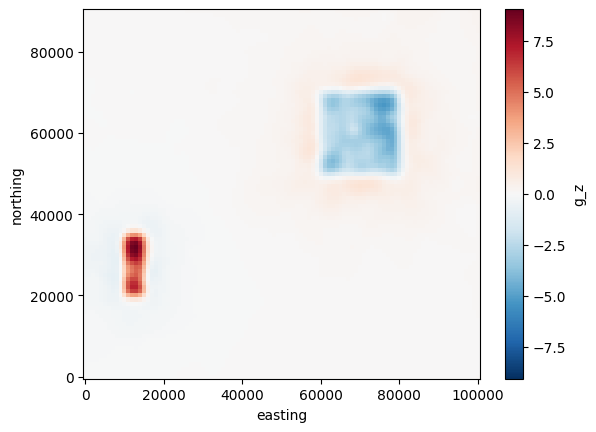

In [36]:
# A diferença calculada abaixo representa o R_2 verdadeiro.

residuo = grid_true - gz_grid_eq
residuo.g_z.plot()

In [43]:
# R_2 verdadeiro

g_z_medio = np.sum(grid_true.g_z.values)/np.size(grid_true.g_z)
residuo_quadrado = np.sum(residuo.g_z.values**2)
R_2_true = 1 - (residuo_quadrado/np.sum([(gz - g_z_medio)**2 for gz in grid_true.g_z.values]))

R_2_true

0.9053606790108185

In [38]:
# Usando validação cruzada para avaliar quão bem o modelo de fontes equivalentes consegue prever com precisão os valores do campo
## Validação cruzada por blocos

# Dados são primeiramente agrupados em blocos retangulares de tamanhos fornecimento pelo argumento "spacing".
# Os blocos são então divididos em teste e treinamento iterivamente através dos k folds do dado.
# (k é dado por "n_splits").

# Variando n_splits e tamanho do bloco

In [53]:
parametros = [ 2, 12, 1000, 10500 ]
##############   n ###  bloco ####################
grade_parametros = vd.grid_coordinates(parametros, spacing=(950,1), meshgrid=False)

n_splits, block = grade_parametros

R_2_media = np.empty(grade_parametros[0].shape)

for i in range (R_2_media.shape[0]):
    R_2_media[i] = np.mean(
        vd.cross_val_score(
        fontes,
        coordinates,
        gz,
        cv=vd.BlockKFold(spacing=block[i], n_splits=n_splits[i], shuffle=True, random_state=123),
    )
)

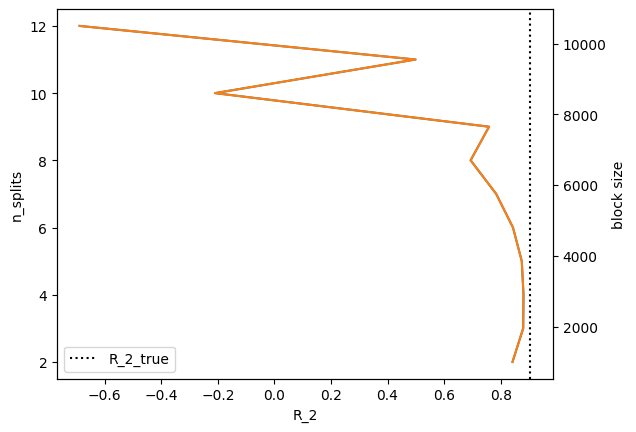

In [54]:
fig, ax = plt.subplots()
#fig.subplots_adjust(right=0.75)

twin1 = ax.twinx()

ax.plot(R_2_media, grade_parametros[0],"C0", label="n_splits")
plt.axvline(x = R_2_true, color = 'black', linestyle = 'dotted', label="R_2_true") 
twin1.plot(R_2_media, grade_parametros[1], "C1", label="block size")
ax.set(xlabel="R_2", ylabel="n_splits")
twin1.set(ylabel="block size")
plt.legend()

In [41]:
parametros = [ 2, 10, 1000, 10500 ]
##############   n ###  bloco ####################
grade_parametros = vd.grid_coordinates(parametros, spacing=(950,1), meshgrid=False)

n_splits, block = grade_parametros

# Vetor para calcular a variação de spacing (tamanho do bloco)
# n_splits definido como 5
R_2_media_s = np.empty(grade_parametros[1].shape)

for i in range (R_2_media_s.shape[0]):
    R_2_media_s[i] = np.mean(
        vd.cross_val_score(
        fontes,
        coordinates,
        gz,
        cv=vd.BlockKFold(spacing=block[i], n_splits=5, shuffle=True, random_state=123),
    )
)

#Vetor para calcular a variação de n_splits
# tamanho do bloco definido como 3000

R_2_media_n = np.empty(grade_parametros[0].shape)

for j in range (R_2_media_n.shape[0]):
    R_2_media_n[j] = np.mean(
        vd.cross_val_score(
        fontes,
        coordinates,
        gz,
        cv=vd.BlockKFold(spacing=3000, n_splits=n_splits[j], shuffle=True, random_state=123),
    )
)

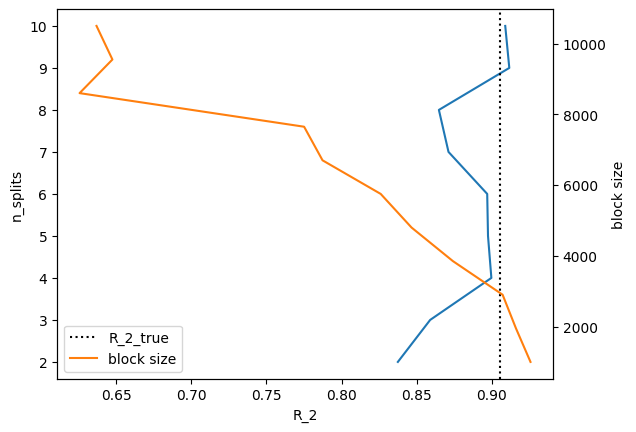

In [52]:
fig, ax = plt.subplots()
# n_splits definido como 5
# tamanho do bloco definido como 3000
twin1 = ax.twinx()

ax.plot(R_2_media_n, grade_parametros[0],"C0", label="n_splits")
plt.axvline(x = R_2_true, color = 'black', linestyle = 'dotted', label="R_2_true") 
twin1.plot(R_2_media_s, grade_parametros[1], "C1", label="block size")
ax.set(xlabel="R_2", ylabel="n_splits")
twin1.set(ylabel="block size")
plt.legend()

In [18]:
parametros = [ 2, 12, 1000, 10500 ]
##############   n ###  bloco ####################
grade_parametros = vd.grid_coordinates(parametros, spacing=(950,1))

n_splits, block = grade_parametros

R_2_media = np.empty(grade_parametros[0].shape)

for i in range (R_2_media.shape[0]):
    for j in range (R_2_media.shape[1]):
        
        R_2_media[i,j] = np.mean(
            vd.cross_val_score(
            fontes,
            coordinates,
            gz,
            cv=vd.BlockKFold(spacing=block[i,j], n_splits=n_splits[i,j], shuffle=True, random_state=123),
        )
    )

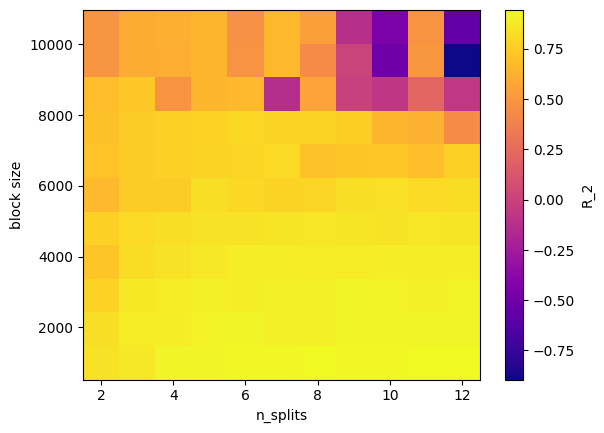

In [26]:
plt.pcolormesh(grade_parametros[0], grade_parametros[1], R_2_media, cmap="plasma")
plt.xlabel("n_splits")
plt.ylabel("block size")
plt.colorbar(label="R_2")

# Levantamento aéreo 

In [55]:
region = [0, 100e3, 0, 90e3] 
# Espaçamento entre as linhas de voo: 5000
spacing = (500,5000) 
coordinates = vd.grid_coordinates(region=region, spacing=spacing, extra_coords=500) # Coordenadas do levantamento 


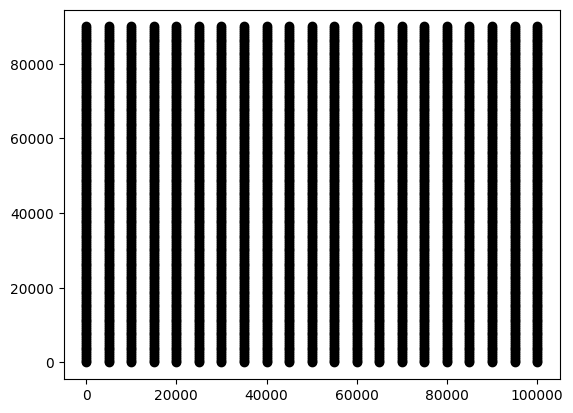

In [58]:
plt.plot(coordinates[0], coordinates[1],'o', color='black')

In [59]:


prismas = [
    [10e3, 15e3, 20e3, 35e3, -1e3,  0],
    [60e3, 80e3, 50e3, 70e3, -2e3,  -0.5e3],
]
densidades = [500, -300]
# efeito gravitacional dos prismas
gz = hm.prism_gravity(coordinates, prismas, densidades, field="g_z")
# criando a malha regular pra plotar o R_2 verdadeiro
# coordenadas da malha regular
grid_coordinates = vd.grid_coordinates(region=region, spacing=2000, extra_coords=500) 
#grid gz 
gz_grid = hm.prism_gravity(grid_coordinates, prismas, densidades, field="g_z") 
#grid regular
grid_true = vd.make_xarray_grid(grid_coordinates, gz_grid, data_names="g_z", extra_coords_names="upward")

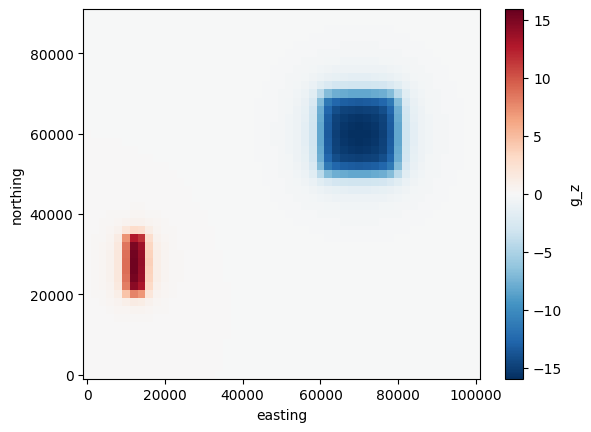

In [60]:
grid_true.g_z.plot()

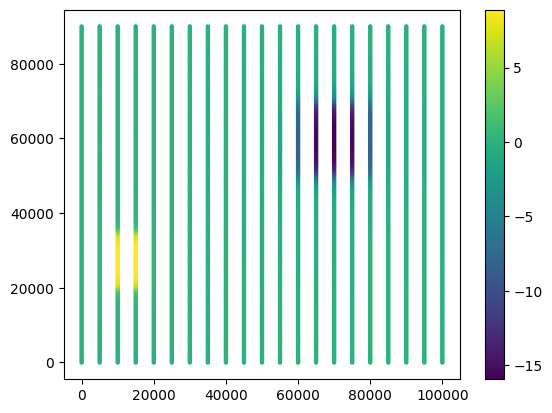

In [61]:
plt.scatter(coordinates[0],coordinates[1],s=5,c=gz)
plt.colorbar() # resultado do levantamento

In [62]:
# gerando modelo de fontes equivalentes

fontes = hm.EquivalentSourcesGB(damping=1,depth=2000)

fontes.fit([coordinates[0],coordinates[1],coordinates[2]],data=gz) 

EquivalentSourcesGB(damping=1, depth=2000)

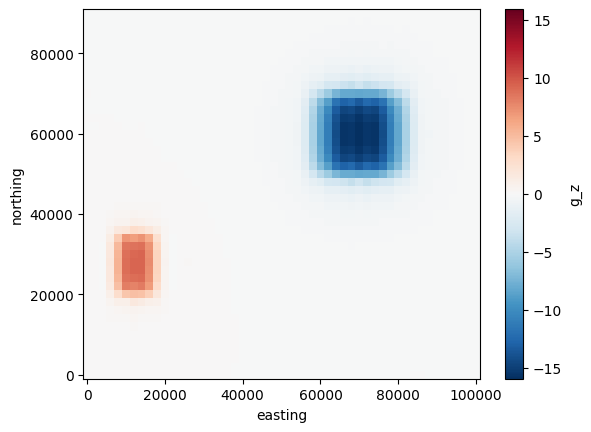

In [63]:
gz_grid_eq = fontes.grid(grid_coordinates,data_names="g_z")
# resultado utilizando fontes equivalentes 
# (interpolação dos dados entre as linhas de voo)
gz_grid_eq.g_z.plot() 

In [1]:
# Plotando a diferença entre grid_true (levantamento na malha regular) e gz_grid_eq (fontes equivalentes)

residuo = grid_true - gz_grid_eq
residuo.g_z.plot()

NameError: name 'grid_true' is not defined

In [65]:
# R_2 verdadeiro 

g_z_medio = np.sum(grid_true.g_z.values)/np.size(grid_true.g_z)
residuo_quadrado = np.sum(residuo.g_z.values**2)
R_2_true = 1 - (residuo_quadrado/np.sum([(gz - g_z_medio)**2 for gz in grid_true.g_z.values]))

R_2_true

0.9600604646857972

In [66]:
parametros = [ 2, 12, 1000, 10500 ]
##############   n ###  bloco ####################
grade_parametros = vd.grid_coordinates(parametros, spacing=(950,1), meshgrid=False)

n_splits, block = grade_parametros

R_2_media = np.empty(grade_parametros[0].shape)

for i in range (R_2_media.shape[0]):
    R_2_media[i] = np.mean(
        vd.cross_val_score(
        fontes,
        coordinates,
        gz,
        cv=vd.BlockKFold(spacing=block[i], n_splits=n_splits[i], shuffle=True, random_state=123),
    )
)

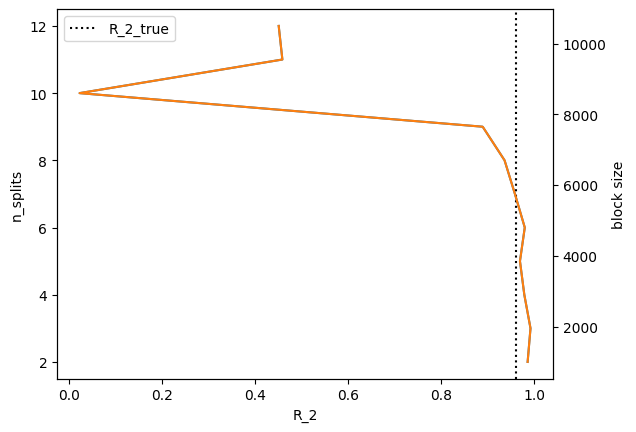

In [67]:
fig, ax = plt.subplots()
#fig.subplots_adjust(right=0.75)

twin1 = ax.twinx()

ax.plot(R_2_media, grade_parametros[0],"C0", label="")
plt.axvline(x = R_2_true, color = 'black', linestyle = 'dotted', label="R_2_true") 
twin1.plot(R_2_media, grade_parametros[1], "C1")
ax.set(xlabel="R_2", ylabel="n_splits")
twin1.set(ylabel="block size")
plt.legend()

In [68]:
parametros = [ 2, 10, 1000, 10500 ]
##############   n ###  bloco ####################
grade_parametros = vd.grid_coordinates(parametros, spacing=(950,1), meshgrid=False)

n_splits, block = grade_parametros

# Vetor para calcular a variação de spacing (tamanho do bloco)
# n_splits definido como 5
R_2_media_s = np.empty(grade_parametros[1].shape)

for i in range (R_2_media_s.shape[0]):
    R_2_media_s[i] = np.mean(
        vd.cross_val_score(
        fontes,
        coordinates,
        gz,
        cv=vd.BlockKFold(spacing=block[i], n_splits=5, shuffle=True, random_state=123),
    )
)

#Vetor para calcular a variação de n_splits
# tamanho do bloco definido como 3000

R_2_media_n = np.empty(grade_parametros[0].shape)

for j in range (R_2_media_n.shape[0]):
    R_2_media_n[j] = np.mean(
        vd.cross_val_score(
        fontes,
        coordinates,
        gz,
        cv=vd.BlockKFold(spacing=3000, n_splits=n_splits[j], shuffle=True, random_state=123),
    )
)

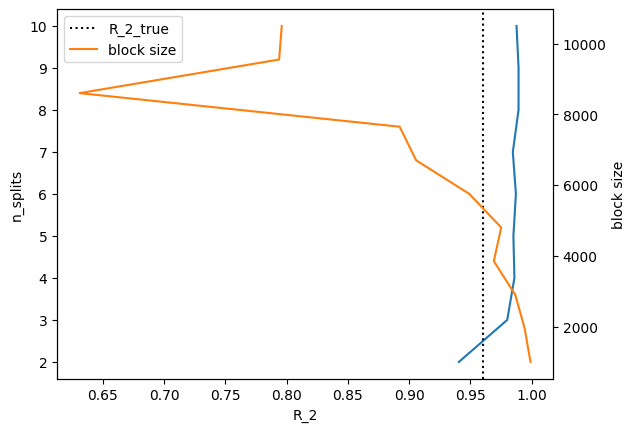

In [69]:
fig, ax = plt.subplots()
# n_splits definido como 5
# tamanho do bloco definido como 3000
twin1 = ax.twinx()

ax.plot(R_2_media_n, grade_parametros[0],"C0", label="n_splits")
plt.axvline(x = R_2_true, color = 'black', linestyle = 'dotted', label="R_2_true") 
twin1.plot(R_2_media_s, grade_parametros[1], "C1", label="block size")
ax.set(xlabel="R_2", ylabel="n_splits")
twin1.set(ylabel="block size")
plt.legend()

In [70]:
parametros = [ 2, 12, 1000, 10500 ]
##############   n ###  bloco ####################
grade_parametros = vd.grid_coordinates(parametros, spacing=(950,1))

n_splits, block = grade_parametros

R_2_media = np.empty(grade_parametros[0].shape)

for i in range (R_2_media.shape[0]):
    for j in range (R_2_media.shape[1]):
        
        R_2_media[i,j] = np.mean(
            vd.cross_val_score(
            fontes,
            coordinates,
            gz,
            cv=vd.BlockKFold(spacing=block[i,j], n_splits=n_splits[i,j], shuffle=True, random_state=123),
        )
    )

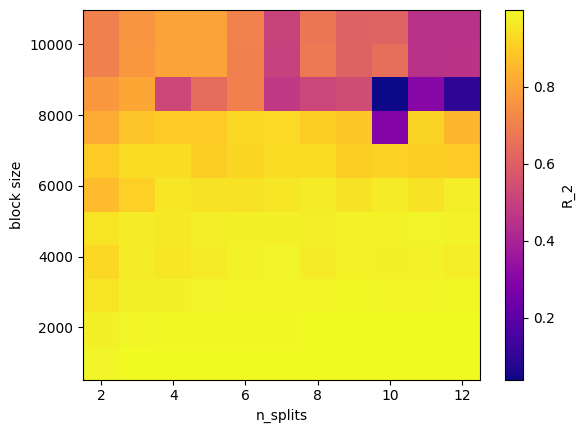

In [71]:
plt.pcolormesh(grade_parametros[0], grade_parametros[1], R_2_media, cmap="plasma")
plt.xlabel("n_splits")
plt.ylabel("block size")
plt.colorbar(label="R_2")